In [2]:
import cv2
import numpy as np
import time
from matplotlib import pyplot as plt

In [3]:
# from calib.txt
#cam0 = [6872.874, 0, 1329.49; 0, 6872.874, 954.485; 0, 0, 1]
#cam1 = [6872.874 0 1623.46; 0 6872.874 954.485; 0 0 1]
f = 6872.874
doffs = 294 # actually 293.97 (pixels) but rounded
baseline = 174.724 # mm
columns = 2912 # width (pixels)
rows = 2020 # height (pixels)
ndisp = 260
isint = 0
vmin = 0
vmax = 238
dyavg = 0
dymax = 0

DOFFS = 294

In [4]:
left_cam = cv2.imread("im0.png")
right_cam = cv2.imread("im1.png")
# left_cam and right_cam are numpy.darry of RGB values

In [5]:
# resizing image to (606, 873)
dim = (int(columns * 0.3), int(rows * 0.3))
left_resize = cv2.resize(left_cam, dim, interpolation = cv2.INTER_AREA)
right_resize = cv2.resize(right_cam, dim, interpolation = cv2.INTER_AREA)

# resetting rows and columns and doffs
columns = 873
rows = 606
doffs = 88

In [6]:
#converting to grayscale 
left_cam_gray = cv2.cvtColor(left_resize, cv2.COLOR_BGR2GRAY)
right_cam_gray = cv2.cvtColor(right_resize, cv2.COLOR_BGR2GRAY)

# using Sobel x to create a gradient
left_cam_gray = cv2.Sobel(left_cam_gray,cv2.CV_64F,1,0,ksize=5)
right_cam_gray = cv2.Sobel(right_cam_gray, cv2.CV_64F,1,0,ksize=5)

In [7]:
# function to find intensity at a single pixel (x,y) in a 11x11 window GRAYSCALE ONLY
def avg_intensity_gray_121(image,x,y):
    window = image[x-5: x+6, y-5: y+6]
    return np.sum(window)/25

# function to find intensity at a single pixel (x,y) in a 9x9 window GRAYSCALE ONLY
def avg_intensity_gray_81(image,x,y):
    window = image[x-4: x+5, y-4: y+5]
    return np.sum(window)/25

# function to find intensity at a single pixel (x,y) in a 7x7 window GRAYSCALE ONLY
def avg_intensity_gray_49(image,x,y):
    window = image[x-3: x+4, y-3: y+4]
    return np.sum(window)/25

# function to find intensity at a single pixel (x,y) in a 5x5 window GRAYSCALE ONLY
def avg_intensity_gray_25(image,x,y):
    window = image[x-2: x+3, y-2: y+3]
    return np.sum(window)/25

# function to find intensity at a single pixel (x,y) in a 3x3 window GRAYSCALE ONLY
def avg_intensity_gray_9(image,x,y):
    window = image[x-1: x+2, y-1: y+2]
    return np.sum(window)/9


In [8]:
# finding avg intensity for left_cam_gray
left_avginten_gray = np.zeros((rows, columns))
for x in range(0, rows):
    for y in range(0, columns):
        if(x == 0 or x == rows - 1 or y == 0 or y == columns - 1):
            left_avginten_gray[x][y] = left_cam_gray[x][y]
        else:
            try:
                #**************************************EDIT HERE**************************************
                #left_avginten_gray[x][y] = avg_intensity_gray_121(left_cam_gray,x,y)
                left_avginten_gray[x][y] = avg_intensity_gray_81(left_cam_gray,x,y)
                #left_avginten_gray[x][y] = avg_intensity_gray_49(left_cam_gray,x,y)
                #left_avginten_gray[x][y] = avg_intensity_gray_25(left_cam_gray,x,y)
                #left_avginten_gray[x][y] = avg_intensity_gray_9(left_cam_gray,x,y)
            except IndexError:
                left_avginten_gray[x][y] = left_cam_gray[x][y]

In [9]:
# finding avg intensity for left_cam_gray
start_time = time.time()
right_avginten_gray = np.zeros((rows, columns))
for x in range(0, rows):
    for y in range(0, columns):
        if(x == 0 or x == rows - 1 or y == 0 or y == columns - 1):
            right_avginten_gray[x][y] = right_cam_gray[x][y]
        else:           
            try:
                #**************************************EDIT HERE**************************************
                #right_avginten_gray[x][y] = avg_intensity_gray_121(right_cam_gray,x,y)
                right_avginten_gray[x][y] = avg_intensity_gray_81(right_cam_gray,x,y)
                #ight_avginten_gray[x][y] = avg_intensity_gray_49(right_cam_gray,x,y)
                #right_avginten_gray[x][y] = avg_intensity_gray_25(right_cam_gray,x,y)
                #right_avginten_gray[x][y] = avg_intensity_gray_9(right_cam_gray,x,y)
            except IndexError:
                right_avginten_gray[x][y] = right_cam_gray[x][y]
print("--- %s seconds ---" % (time.time() - start_time))

--- 2.7526395320892334 seconds ---


In [10]:
# checking dimensions before continuing
left_cam_gray.shape, left_avginten_gray.shape

((606, 873), (606, 873))

<h2> Creating Disparity Map

In [11]:
# we do not need the entirety of intensity values for both images. while # rows are retained, we shorten the columns by the 
# following amounts
# left: [doffs : Xl_max]
# right: [0 : Xr_max - doffs]  
# we want 2020 rows and 2618 columns
f_left_bar = left_avginten_gray[:,doffs:]
f_right_bar = right_avginten_gray[:,0:columns - doffs]

# setting the same boundaries on the original images
f_left = left_cam_gray[:,doffs:]
f_right = right_cam_gray[:,0:columns - doffs]

In [12]:
# function to find correlation values in 11x11 window GRAYSCALE 
def correlation_121(f_left, f_left_bar, f_right, f_right_bar, x, y, d):
    # centered at (x,y)
    window_left = f_left[x-5: x+6, y-5: y+6] - f_left_bar[x,y]
    window_right = f_right[x-5: x+6, y-5 + d: y+6 + d] - f_right_bar[x,y]
    
    # numerator = covariance
    cov = np.sum(np.multiply(window_left, window_right))
    
    # denominator split into 2 parts: variance of the left image and variance of the right image
        # left image 
    var_left = np.sum(np.multiply(window_left, window_left))
        # right image
    var_right = np.sum(np.multiply(window_right, window_right))
    
    return cov/(var_left * var_right)**0.5

# function to find correlation values in 9x9 window GRAYSCALE 
def correlation_81(f_left, f_left_bar, f_right, f_right_bar, x, y, d):
    # centered at (x,y)
    window_left = f_left[x-4: x+5, y-4: y+5] - f_left_bar[x,y]
    window_right = f_right[x-4: x+5, y-4 + d: y+5 + d] - f_right_bar[x,y]
    
    # numerator = covariance
    cov = np.sum(np.multiply(window_left, window_right))
    
    # denominator split into 2 parts: variance of the left image and variance of the right image
        # left image 
    var_left = np.sum(np.multiply(window_left, window_left))
        # right image
    var_right = np.sum(np.multiply(window_right, window_right))
    
    return cov/(var_left * var_right)**0.5

# function to find correlation values in 7x7 window GRAYSCALE 
def correlation_49(f_left, f_left_bar, f_right, f_right_bar, x, y, d):
    # centered at (x,y)
    window_left = f_left[x-3: x+4, y-3: y+4] - f_left_bar[x,y]
    window_right = f_right[x-3: x+4, y-3 + d: y+4 + d] - f_right_bar[x,y]
    
    # numerator = covariance
    cov = np.sum(np.multiply(window_left, window_right))
    
    # denominator split into 2 parts: variance of the left image and variance of the right image
        # left image 
    var_left = np.sum(np.multiply(window_left, window_left))
        # right image
    var_right = np.sum(np.multiply(window_right, window_right))
    
    return cov/(var_left * var_right)**0.5

# function to find correlation values in 5x5 window GRAYSCALE 
def correlation_25(f_left, f_left_bar, f_right, f_right_bar, x, y, d):
    # centered at (x,y)
    window_left = f_left[x-2: x+3, y-2: y+3] - f_left_bar[x,y]
    window_right = f_right[x-2: x+3, y-2 + d: y+3 + d] - f_right_bar[x,y]
    
    # numerator = covariance
    cov = np.sum(np.multiply(window_left, window_right))
    
    # denominator split into 2 parts: variance of the left image and variance of the right image
        # left image 
    var_left = np.sum(np.multiply(window_left, window_left))
        # right image
    var_right = np.sum(np.multiply(window_right, window_right))
    
    return cov/(var_left * var_right)**0.5

# function to find correlation values in 3x3 window GRAYSCALE 
def correlation_9(f_left, f_left_bar, f_right, f_right_bar, x, y, d):
    # centered at (x,y)
    window_left = f_left[x-1: x+2, y-1: y+2] - f_left_bar[x,y]
    window_right = f_right[x-1: x+2, y-1+d: y+2+d] - f_right_bar[x,y]
    
    # numerator = covariance
    cov = np.sum(np.multiply(window_left, window_right))
    
    # denominator split into 2 parts: variance of the left image and variance of the right image
        # left image 
    var_left = np.sum(np.multiply(window_left, window_left))
        # right image
    var_right = np.sum(np.multiply(window_right, window_right))
    
    return cov/(var_left * var_right)**0.5



In [13]:
# setting new rows and column dimensions for disparity map
disparity_x, disparity_y = f_left.shape
disparity = np.zeros((disparity_x, disparity_y ))
#disparity_x, disparity_y 

In [14]:
# checking dimensions again before moving ahead
f_left.shape, f_left_bar.shape, f_right.shape, f_right_bar.shape

((606, 785), (606, 785), (606, 785), (606, 785))

In [15]:
# using left image as reference
# ndsip = 104 #for reduction factor of 0.4
# ndisp = 78  #for reduction factor of 0.3
# ndsip = 65  #for reduction factor of 0.25
ndisp = 78

start_time = time.time() # to measure time
for x in range(4, disparity_x - 5):
    i = ndisp 
    for y in range(4, disparity_y - 5):
        corr = []
        if(y >= disparity_y - ndisp - 4):
            i -= 1
        for d in range(min(ndisp, i)):
            #print(x,y,d,i)
            corr += [correlation_81(f_left, f_left_bar, f_right, f_right_bar, x, y, d)]      
        disparity[x,y] = corr.index(max(corr))
print("--- %s seconds ---" % (time.time() - start_time))

--- 668.6360549926758 seconds ---


In [16]:
# to prevent corruption of my disparity fnc
copy = disparity

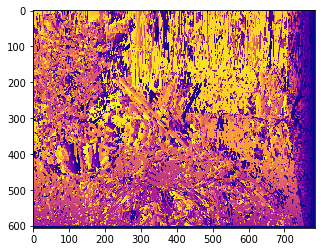

In [17]:
from matplotlib import pyplot as plt
plt.imshow(copy, cmap="plasma")
plt.savefig('sword_sobelx.png')
plt.show()

In [18]:
norm_image = cv2.normalize(copy, None, alpha = 0, beta = 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
cv2.imshow('norm_image', norm_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [19]:
x=4
y=4
d=1
window_left = f_left[x-4: x+5, y-4: y+5] 
window_right = f_right[x-4: x+5, y-4 + d: y+5 + d] 
window_left.shape, window_right.shape

((9, 9), (9, 9))

In [ ]:
# from calib.txt
#cam0 = [6872.874, 0, 1329.49; 0, 6872.874, 954.485; 0, 0, 1]
#cam1 = [6872.874 0 1623.46; 0 6872.874 954.485; 0 0 1]
doffs = 294 # actually 293.97 (pixels) but rounded
baseline = 174.724 # mm
columns = 2912 # width (pixels)
rows = 2020 # height (pixels)
ndisp = 260
isint = 0
vmin = 0
vmax = 238
dyavg = 0
dymax = 0

In [ ]:
# calculating depth (z-axis) using z = baseline * f /(d + doffs)
baseline = baseline * 0.4
f = f * 0.4
doffs = DOFFS * 0.4
Z = baseline * f/(disparity + doffs)